In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.patches import Ellipse

from scipy.interpolate import griddata

plt.rcParams.update({'font.size': 12})

np.random.seed(4)

from scipy import stats
from scipy.stats import norm, uniform
import scipy.optimize
from numpy.linalg import inv

In [2]:
# import internal files
import emulators
import utils
import historymatch
import plot

In [3]:
def model_eqn_1(x, theta_0, theta_1, theta_2):
    return theta_0 + theta_1*(x) + theta_2*(x**2)
    
function1 = np.vectorize(model_eqn_1)

In [4]:
def model_eqn_2(x, theta_0, theta_1, theta_2):
    return theta_0 - theta_1*np.sin(x) + theta_2*np.cos(x)

function2 = np.vectorize(model_eqn_2)

In [5]:
def toy_model3D(theta_1, theta_2, theta_3):
    
    x_bound = np.array([0.1, 1])
    Nx = 4
    xvals = np.linspace(x_bound[0], x_bound[-1], Nx)

    outputs =  []
    for x in xvals:
        output = theta_1 + theta_2*(x) + theta_3*(x**2)
        outputs.append(output)
    for x in xvals:
        output = theta_1 - theta_2*np.sin(x) + theta_3*np.cos(x)
        outputs.append(output)
    return np.array(outputs)

In [6]:
# define parameter space
x_bound = np.array([0.1, 1])
Nx = 4
xvals = np.linspace(x_bound[0], x_bound[-1], Nx)

theta_0_bound = np.array([-1, 1]).reshape(1,-1)
theta_1_bound = np.array([-1, 1]).reshape(1,-1)
theta_2_bound = np.array([-1, 1]).reshape(1,-1)

parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound, theta_2_bound), axis=0)

#parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound), axis=0)

theta_0_vals = np.linspace(parameter_bounds[0,0], parameter_bounds[0,1], 100)
theta_1_vals = np.linspace(parameter_bounds[1,0], parameter_bounds[1,1], 100)
theta_2_vals = np.linspace(parameter_bounds[2,0], parameter_bounds[2,1], 100)


theta_vals = np.concatenate((theta_0_vals.reshape(1,-1), theta_1_vals.reshape(1,-1), theta_2_vals.reshape(1,-1)), axis=0)

#theta_vals = np.concatenate((theta_0_vals.reshape(1,-1), theta_1_vals.reshape(1,-1)), axis=0)

In [7]:
# for testing: true datapoints
true_parameters = [-0.1, 0.3, 0.6]
ndim = len(true_parameters)

var_exp_f1 = 0.01        # observational uncertainty variance
var_exp_f2 = 0.01

error_f1 = np.random.normal(0, var_exp_f1, len(xvals))
error_f2 = np.random.normal(0, var_exp_f2, len(xvals))

#z_1 = function1(xvals, true_parameters[0], true_parameters[1], true_parameters[2])+ np.random.normal(0, var_exp_f1) # observed datapoint
z_1 = function1(xvals, true_parameters[0], true_parameters[1], true_parameters[2]) + error_f1 # observed datapoint

z_2 = function2(xvals, true_parameters[0], true_parameters[1], true_parameters[2]) + error_f2  # observed datapoint

#z_1 = function1(xvals, true_parameters[0], true_parameters[1]) + error_f1 # observed datapoint
#z_2 = function2(xvals, true_parameters[0], true_parameters[1]) + error_f2  # observed datapoint



In [8]:
#obs_data_all = toy_model3D(*true_parameters) + error_f1

Text(0, 0.5, '$z_{2}$')

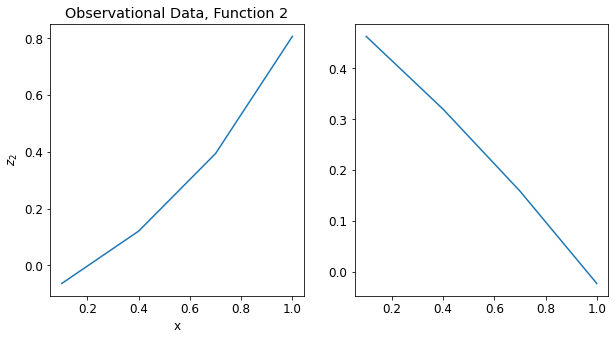

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))


ax1.plot(xvals, z_1)
ax2.plot(xvals, z_2)

ax1.set_title('Observational Data, Function 1')
ax1.set_title('Observational Data, Function 2')

ax1.set_xlabel('x')
ax1.set_ylabel(r'$z_{1}$')
ax1.set_xlabel('x')
ax1.set_ylabel(r'$z_{2}$')

In [10]:
def design_matrix_f1(x, p=3):
    X_d = np.zeros((len(x),p))
    for i in range(p):
        X_d[:,i] = x**i
    return X_d

def design_matrix_f2(x, p=3):
    X_d = np.zeros((len(x),p))
    X_d[:,0] = 1
    X_d[:,1] = -np.sin(x)
    X_d[:,2] = np.cos(x)
    return X_d


# Create design matrix
X1 = design_matrix_f1(xvals, p=3)
print(X1)
X2 = design_matrix_f2(xvals, p=3)


[[1.   0.1  0.01]
 [1.   0.4  0.16]
 [1.   0.7  0.49]
 [1.   1.   1.  ]]


In [11]:
def A_matrix(X_d, variance):
    for i in range(X_d.shape[0]):
        X_d[i] = X_d[i] / np.sqrt(variance)
    return X_d

In [12]:
A1 = A_matrix(X1, var_exp_f1)
b1 = z_1 / np.sqrt(var_exp_f1)

A2 = A_matrix(X2, var_exp_f2)
b2 = z_2 / np.sqrt(var_exp_f2)

In [13]:
def solve_theta(A, b):
    theta_best = ((np.linalg.inv(A.T.dot(A))).dot(A.T)).dot(b)
    return theta_best.flatten()

In [14]:
print(A1)

thet = solve_theta(A1,b1)

print(thet)

print(b1)

[[10.   1.   0.1]
 [10.   4.   1.6]
 [10.   7.   4.9]
 [10.  10.  10. ]]
[-0.09362872  0.26355168  0.63444772]
[-0.63494383  1.20999513  3.94040911  8.06935985]


In [15]:
def H_matrix(A):
    return np.linalg.inv(A.T.dot(A))

In [16]:
def covariance(X_d, variance):
    return variance*np.linalg.inv(X_d.T.dot(X_d))

In [17]:
cov_matrix_f1 = covariance(X1, var_exp_f1)
cov_matrix_f2 = covariance(X2, var_exp_f2)
theta_f1 = solve_theta(A1, b1)
theta_f2 = solve_theta(A2, b2)

true_thetas = [theta_f1, theta_f2]


H1 = H_matrix(A1)
H2 = H_matrix(A2)


In [18]:
# calculate product of posteriors
H3 = inv(inv(H1) + inv(H2))

H32 =  H1.dot( inv(H1 + H2).dot(H2) )

L1 = inv(np.linalg.cholesky(H1 + H2)).dot(H1)
L2 = inv(np.linalg.cholesky(H1 + H2)).dot(H2)

H33 = np.dot(L1.T, L2)

TM_mean = np.dot(np.dot(H3,inv(H1)),theta_f1) + np.dot(np.dot(H3,inv(H2)),theta_f2)

print(H3)
print(H32)
print(H33)

[[ 0.00500388 -0.00037699 -0.00613499]
 [-0.00037699  0.00342433  0.00045998]
 [-0.00613499  0.00045998  0.01003366]]
[[ 0.00500388 -0.00037699 -0.00613499]
 [-0.00037699  0.00342433  0.00045998]
 [-0.00613499  0.00045998  0.01003366]]
[[ 0.00500388 -0.00037699 -0.00613499]
 [-0.00037699  0.00342433  0.00045998]
 [-0.00613499  0.00045998  0.01003366]]


In [19]:
def get_cov_ellipse(cov, centre, nstd, ax, color):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * nstd * np.sqrt(np.abs(eigvals))
    
    t = np.linspace(0, 2*np.pi, 100)
    Ell = np.array([0.5*width*np.cos(t) , 0.5*height*np.sin(t)]) 
    R_rot = np.array([[np.cos(theta) , -np.sin(theta)],[np.sin(theta), np.cos(theta)]])  
    Ell_rot = np.zeros((2,Ell.shape[1]))
    for i in range(Ell.shape[1]):
        Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])
    
    ax.plot( centre[0]+Ell_rot[0,:] , centre[1]+Ell_rot[1,:], color=color)
    #ax.plot(Ell_rot[:,0], Ell_rot[:,1])

In [20]:
def plot_ellipses(fig, parameter_bounds, true_parameters, H, theta_best, theta_vals, color):
    theta_names = [r'$\theta_{1}$', r'$\theta_{2}$', r'$\theta_{3}$']
    N = len(theta_best)
    for i in range(N):
        for j in range(N):
            ax = fig.axes[i + N*j]
            if i != 0:
                ax.axes.yaxis.set_visible(False)
                
            if i == j:
                if color == 'mediumaquamarine':
                    ax_right = ax.twinx()
                    ax_right.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], theta_best[i], np.sqrt(H[i,i])), color=color)
                    ax_right.set_title(str(theta_names[i]) + '=' + str(round(theta_best[i], 2)), fontsize=14)
                
            elif i < j:
                
                cov_matrix = np.array([[H[i,i], H[i,j]],[H[j,i], H[j,j]]])
                get_cov_ellipse(cov_matrix, [theta_best[i], theta_best[j]], 3, ax, color)
                ax.set_ylabel(theta_names[j])
                ax.set_xlabel(theta_names[i])
                ax.set_xlim([parameter_bounds[i,0], parameter_bounds[i,1]])
                ax.set_ylim([parameter_bounds[j,0], parameter_bounds[j,1]])
                
            else:
                ax.axis('off')

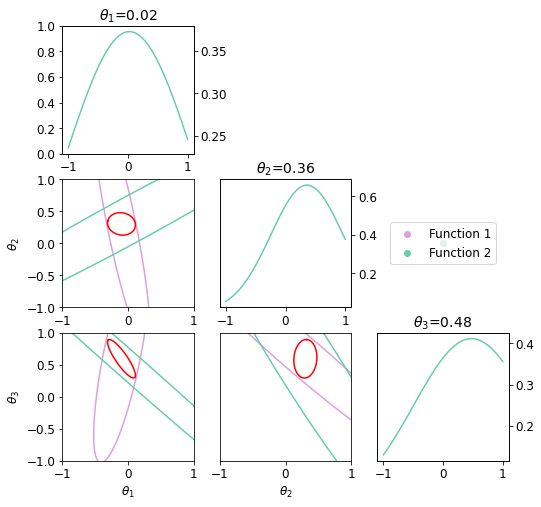

In [21]:
color_list = ['plum', 'mediumaquamarine', 'red']
N = ndim
fig, axes = plt.subplots(N,N,figsize=(8,8))

ax = fig.axes[5]
plot_ellipses(fig, parameter_bounds, true_parameters, H1, theta_f1, theta_vals, color_list[0])
plot_ellipses(fig, parameter_bounds, true_parameters, H2, theta_f2, theta_vals, color_list[1])
plot_ellipses(fig, parameter_bounds, true_parameters, H3, TM_mean, theta_vals, color_list[2])


ax.scatter(1,1,color=color_list[0],label='Function 1')
ax.scatter(1,1,color=color_list[1],label='Function 2')
ax.legend(loc='center')

In [22]:
file2 = open("3D_analytic_mean.txt", "w")

np.savetxt(file2, TM_mean)
    
file2.close()

file1 = open("3D_analytic_cov.txt", "w")

for i in range(H3.shape[0]):
    np.savetxt(file1, H3[i])
    
file1.close()




In [23]:
# create squared-exponential kernel
sigma_cov = 0.1        # sqrt variance of covariance function
beta = 0         # prior expectation
theta = 1
var_method=0

sigma_n = 0.1

#kern = kernels.SE()

# simulation parameters
Ntraining = 30          # number of training points
ndim = 3    # model dimensions
Nsamples = 5000    # number of test points

#true_model = [model_eqn_1]
true_model = [model_eqn_1, model_eqn_2]
#obs_data = z_1.reshape(1,-1)
obs_data = np.concatenate((z_1.reshape(1,-1),z_2.reshape(1,-1)), axis=0)

print(obs_data)


[[-0.06349438  0.12099951  0.39404091  0.80693599]
 [ 0.46286946  0.31996532  0.15916294 -0.02227416]]


In [24]:
thetatest = [1,2,3]

for i in range(len(true_model)):
    print(true_model[i](xvals,1,2,3))

[1.23 2.28 3.87 6.  ]
[3.78534566 2.9843463  2.00609119 0.93796495]


In [25]:
n_waves = 3


#ctr, cov, nonimp, ell = historymatch.history_match(true_model, obs_data, xvals, kern, ndim, Nsamples, Ntraining,
                           parameter_bounds, var_method, var_exp_f1, sigma_cov,
                           beta, theta, sigma_n, [H1,H2], true_thetas,
                           noise=False, waves=n_waves)

IndentationError: unexpected indent (<ipython-input-25-776a459c344f>, line 5)

In [ ]:
def plot_ellipsoid_3d(ell, ax):
    """Plot the 3-d Ellipsoid ell on the Axes3D ax."""

    # points on unit sphere
    u = np.linspace(0.0, 2.0 * np.pi, 100)
    v = np.linspace(0.0, np.pi, 100)
    z = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    x = np.outer(np.ones_like(u), np.cos(v))

    # transform points to ellipsoid
    for i in range(len(x)):
        for j in range(len(x)):
            x[i,j], y[i,j], z[i,j] = ell.ctr + np.dot(ell.axes,
                                                      [x[i,j],y[i,j],z[i,j]])

    ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='#2980b9', alpha=0.2)